In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
%matplotlib inline

### Downloading and loading the dataset

In [35]:
# Credits to ritvik and his YouTube channel ritvikmath for the dataset

fish_dataset_url = "https://raw.githubusercontent.com/ritvikmath/YouTubeVideoCode/main/fish.csv"

# We can access the content (csv file) from the github repository with the help of the requests.get() function
res = requests.get(fish_dataset_url, allow_redirects = True)

# We then write the content of the requested object into a csv file named fish_dataset which will get created if there isn't a file with this name
with open('fish_dataset.csv', 'wb') as file:
    file.write(res.content)
    
fish_df = pd.read_csv('fish_dataset.csv')

### Visualizing the data on a 2-D plot

Text(0, 0.5, 'Weight')

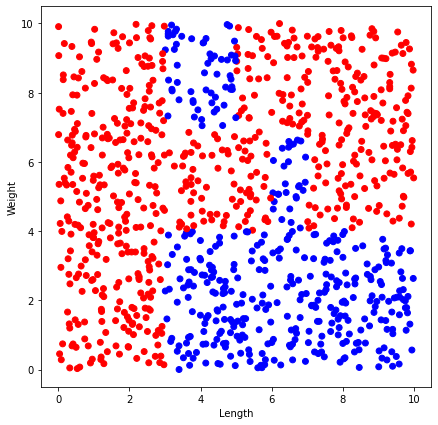

In [36]:
plt.figure(figsize=(7, 7))
plt.scatter(fish_df.length, fish_df.weight, color=['red' if t == 'tuna' else 'blue' for t in fish_df.type], s=35)
plt.xlabel('Length')
plt.ylabel('Weight')

In [37]:
fish_df.head()

,length,weight,type
0,8.618381,7.848030,tuna
1,2.522046,8.762507,tuna
2,2.035690,7.101971,tuna
3,6.695008,4.953932,salmon
4,9.834069,7.908453,tuna


In [38]:
# Converting the type (which is in 'tuna' and 'salmon') into numerical values (1 and 0)
fish_df.type = fish_df.type.apply(lambda x: 1 if x == 'tuna' else 0)

### Our very own DecisionTreeClassifier implementation

In [72]:
class DecisionTreeClassifier:
    def __init__(self, max_depth = 3, min_samples_split = 2, best_params = {}):
        # The meaning of the parameters can be better understood from sklearn's official documentation on Decision Tree Classifiers
        # documentation: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.best_params = best_params

    def __get_entropy(self, values):
        # We expect that the target values (y) will be LabelEncoded and thus, we will get classes labelled as 0, 1, ..., num_classes - 1
        if len(values) == 0:
            return 0
        # Get the maximum class value, say there are 3 classes, then max_class = 3
        max_class = max(values)
        # We need max_class+1 sized counts array. 
        # This can be understood by the example when there are just class-3 elements present => counts = [0, 0, 0, len(values)]
        counts = np.full((max_class+1,), 0)
        for val in values:
            # print("val =", val)
            counts[val] += 1
        
        # Calculate the corresponding probabilities
        probabilities = counts / len(values)
        entropy = 0
        # Calculate the entropy using these probabilities
        for prob in probabilities:
            if prob == 1:
                return 0
            elif prob == 0:
                continue
            entropy -= (prob * np.log2(prob))
        return entropy
    
    def __get_entropy_from_split(self, df, feature, split_val):
        # Get the split dataframes based on the split value for the splitting feature
        left_vals = df[df[feature] < split_val].type
        right_vals = df[df[feature] >= split_val].type
        
        # Our task is to find the weighted entropy of the split dataframe
        prob_left = len(left_vals)/len(df)
        prob_right = len(right_vals)/len(df)
        
        left_entropy = self.__get_entropy(left_vals)
        right_entropy = self.__get_entropy(right_vals)
        
        weighted_entropy = (left_entropy * prob_left) + (right_entropy * prob_right)
        return weighted_entropy
        
    def train(self, df, step_value = 0.1, entropy_threshold = 1e-1):
        # Checking the base condition of depth of the tree
        if(self.max_depth <= 0):
            return

        # Temporary variables for checking whether we got a split in the current dataframe or not and for updating the best parameters accordingly
        best_feature = ""
        best_value = np.inf
        best_entropy = self.__get_entropy(df.type)

        for f in df.columns[:-1]:
            # We will start from the minumum value of the feature f and increment it by some value, each time checking if splitting it at that value gives us less entropy (randomness)
            curr = df[f].min()
            while curr < df[f].max():
                curr_entropy = self.__get_entropy_from_split(df, f, curr)
                if curr_entropy < best_entropy:
                    best_entropy = curr_entropy
                    best_feature = f
                    best_value = curr
                curr += step_value
        
        # Checking if we were able to get a better split by comparing the entropy achieved with that of the unsplit dataframe
        if(best_feature == ""):
            return

        # Updating the best_param_values
        self.best_params["feature"].append(best_feature)
        self.best_params["value"].append(best_value)
        self.best_params["entropy"].append(best_entropy)

        # print("Feature =", self.best_params['feature'][-1])
        # print("Value =", self.best_params['value'][-1])
        # print("Entropy =", self.best_params['entropy'][-1])
        
        # Getting the split dataframes
        left_df = df[df[self.best_params['feature'][-1]] < self.best_params['value'][-1]]
        right_df = df[df[self.best_params['feature'][-1]] >= self.best_params['value'][-1]]

        # Getting their entropies for comparing with the entropy threshold
        left_entropy = self.__get_entropy(left_df.type)
        right_entropy = self.__get_entropy(right_df.type)

        # print("left_entropy =", left_entropy)
        # print("right_entropy =", right_entropy)
        
        self.max_depth -= 1

        if right_entropy > entropy_threshold and len(right_df) >= self.min_samples_split:
            return self.train(df = right_df)
        if left_entropy > entropy_threshold and len(left_df) >= self.min_samples_split:
            return self.train(df = left_df)
        
        return


    def plot_decision_tree(self, df):
        '''Plot the Decision Tree boundaries on a 2-D plot. This method should and can only be used for datasets having 2 features'''
        features = list(df.columns[:-1])
        
        plt.figure(figsize=(7, 7))
        plt.scatter(fish_df[features[0]], fish_df[features[1]], color=['red' if t == 1 else 'blue' for t in fish_df.type], s=35)
        plt.xlabel(f"{features[0]}")
        plt.ylabel(f"{features[1]}")

        for i in df.columns[:-1]:
            for j in range(len(self.best_params['entropy'])):
                if self.best_params['feature'][j] == i:
                    val = self.best_params['value'][j]
                
                    if i == features[0]:
                        y_min = df[features[1]].min()
                        y_max = df[features[1]].max()
                        plt.scatter(np.linspace(val, val, 100), np.linspace(y_min, y_max, 100), s=15, marker='+', c='black')
                    elif i == features[1]:
                        x_min = df[features[0]].min()
                        x_max = df[features[0]].max()
                        plt.scatter(np.linspace(x_min, x_max, 100), np.linspace(val, val, 100), s = 15, marker='+', c = 'black')
        
        plt.show()


In [73]:
best_param_values = {'feature': [], 'value': [], 'entropy': []}

decision_tree = DecisionTreeClassifier(max_depth = 5, min_samples_split = 4, best_params=best_param_values)
decision_tree.train(fish_df)

In [74]:
best_param_values

{'entropy': [0.6843553171032571,
  0.426763555582736,
  0.5524718527527053,
  0.8910285838233681,
  0.4995710519959544],
 'feature': ['length', 'weight', 'length', 'length', 'weight'],
 'value': [3.0065456626365483,
  4.001260199577321,
  7.008879131610914,
  5.008879131610921,
  6.725588309292307]}

### Visulization of our model's performance

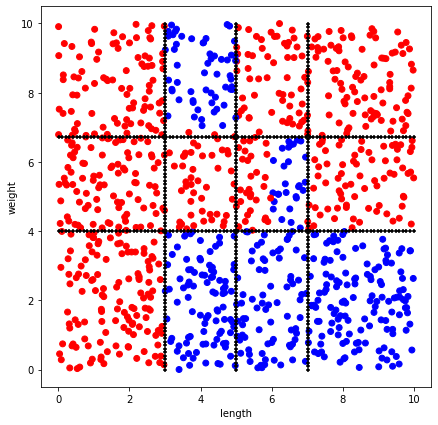

In [75]:
decision_tree.plot_decision_tree(fish_df)

### Scikit-Learn's Implementation of DecisionTreeClassifier on our Dataset

In [76]:
from sklearn.tree import DecisionTreeClassifier

In [86]:
model = DecisionTreeClassifier(max_depth = 5, min_samples_split = 4, criterion="entropy")
model.fit(fish_df.iloc[:, :-1], fish_df.iloc[:, -1])

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_split=4)

In [87]:
from sklearn.tree import plot_tree

### Comparing Scikit-Learn's model with our implementation

{'feature': ['length', 'weight', 'length', 'length', 'weight'], 'value': [3.0065456626365483, 4.001260199577321, 7.008879131610914, 5.008879131610921, 6.725588309292307], 'entropy': [0.6843553171032571, 0.426763555582736, 0.5524718527527053, 0.8910285838233681, 0.4995710519959544]}


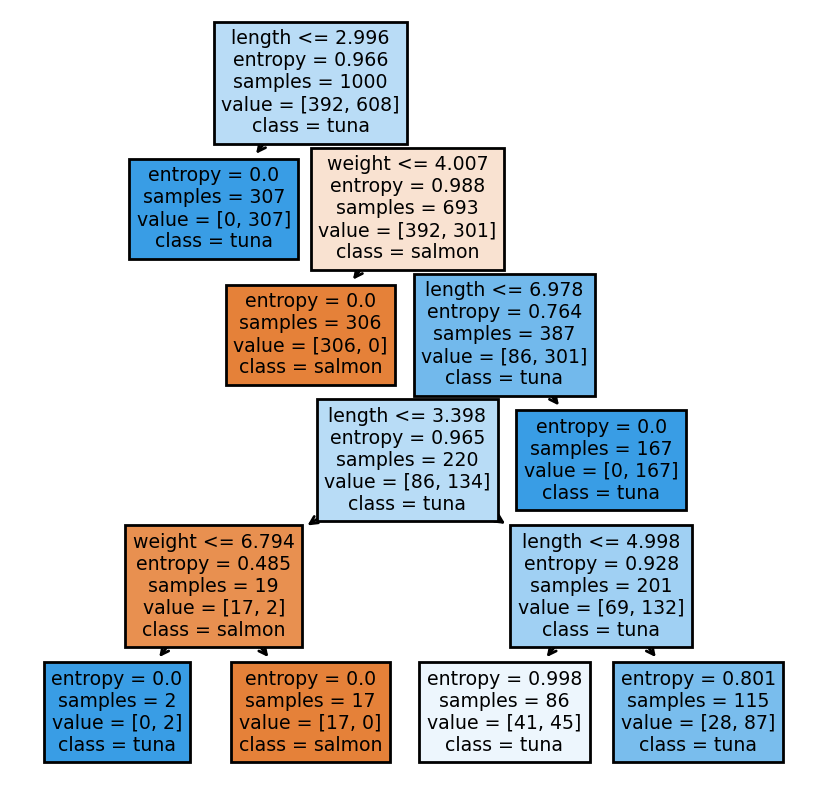

In [93]:
fn=['length','weight']
cn=['salmon', 'tuna']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (5,5), dpi=200)
plot_tree(model,
               feature_names = fn, 
               class_names=cn,
               filled = True);

print(best_param_values)

#### On comparing our model with sklearn's implementation of DecisionTreeClassifer, we can see that the splits are very similar and differ only by the order of $10^{-2}$ or $0.01$ which confirms the correctness of our implementation
